# Predict the class of bike riders. 

<center>
    <img src = images/nycbike.png width = 80%/>
</center>

In this dataset, we will explore the new york city bike rider's trips. The information about the rider's trip is located <a href="https://ride.citibikenyc.com/system-data">here</a>. For the capstone project, we will be taking information from May 2022 to November 2022. At the time of beginning this project, data for december 2022 is not available. The dataset contains information on 676k trip riders from the last 6 months. 

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>

For this capstone project, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.

# Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

## 1.1) Business Question

Given a dataset containing information bike riders trip attributes, predict the class of biker riders. 

## 1.2) Understanding of Business

Citibank nyc publishes the bike riders trip data every month. The data contains information which will help to answer the following questions 
###### 1) Where do Citi Bikers ride? 
###### 2) When do they ride? 
###### 3) How far do they go? 
###### 4) Which stations are most popular? 
###### 5) What days of the week are most rides taken on?

# Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In order to understand the data, some required libraries are imported to run few basic stats about the data. Navigating through the dataset using shape to determine the number of rows and columns and using the describe and info function to determine the mean,std and count along with the type of columns will help in next steps. 

## 2.1) Data Collection - Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta

import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from scipy import stats  as ss
from geopy.distance import geodesic
import holidays

from sklearn import preprocessing as pp
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from imblearn import combine as c

import warnings
warnings.filterwarnings("ignore")


## 2.2) Data Collection - Load Data

The below files were downloaded from the repository containing complete history of NYC Citi bike rides located <a href="https://s3.amazonaws.com/tripdata/index.html">here</a>. I have used files only for the year 2022 to explore and run machine learning algorithms. 

In [36]:
df_202211_raw = pd.read_csv('data/JC-202211-citibike-tripdata.csv')
df_202210_raw = pd.read_csv('data/JC-202210-citibike-tripdata.csv')
df_202209_raw = pd.read_csv('data/JC-202209-citibike-tripdata.csv')
df_202208_raw = pd.read_csv('data/JC-202208-citibike-tripdata.csv')
df_202207_raw = pd.read_csv('data/JC-202207-citbike-tripdata.csv')
df_202206_raw = pd.read_csv('data/JC-202206-citibike-tripdata.csv')
df_202205_raw = pd.read_csv('data/JC-202205-citibike-tripdata.csv')
df_202204_raw = pd.read_csv('data/JC-202204-citibike-tripdata.csv')
df_202203_raw = pd.read_csv('data/JC-202203-citibike-tripdata.csv')
df_202202_raw = pd.read_csv('data/JC-202202-citibike-tripdata.csv')
df_202201_raw = pd.read_csv('data/JC-202201-citibike-tripdata.csv')

df_raw = pd.concat( [
                     df_202201_raw,
                     df_202202_raw,
                     df_202203_raw,
                     df_202204_raw,
                     df_202205_raw, 
                     df_202206_raw,
                     df_202207_raw,
                     df_202208_raw,
                     df_202209_raw,
                     df_202210_raw,
                     df_202211_raw
                    ] )

## 2.3 Data Collection - Describe Data

In [37]:
df_raw.describe()

,start_lat,start_lng,end_lat,end_lng
count,846900.000000,846900.000000,845013.000000,845013.000000
mean,40.731910,-74.040440,40.731854,-74.040193
std,0.012108,0.012217,0.012235,0.012182
min,40.706495,-74.088964,40.640000,-74.140000
25%,40.721124,-74.046305,40.721124,-74.045953
50%,40.733670,-74.037977,40.733670,-74.037683
75%,40.740973,-74.030970,40.740973,-74.030970
max,40.754992,-74.023587,40.872412,-73.888271


## 2.4 Data Collection - Data Types

In [38]:
df_raw.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

## 2.5) Data Collection - Data Dimensions

In [39]:
df_raw.shape

(846900, 13)

## 2.6) Data Collection - Check NA

In [40]:
df_raw.isna().sum()

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name      10
start_station_id        10
end_station_name      2996
end_station_id        2996
start_lat                0
start_lng                0
end_lat               1887
end_lng               1887
member_casual            0
dtype: int64

# Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

## 3.1 Numerical and Categorical Attributes

I will convert the started and ended objects to a datetime objects and the start_station_id and end_station_id to strings.  

In [41]:
df_raw['started_at'] = pd.to_datetime( df_raw['started_at'] )
df_raw['ended_at'] = pd.to_datetime( df_raw['ended_at'] )

In [42]:
df_raw['start_station_id'] = df_raw['start_station_id'].apply( lambda x: str(x) )
df_raw['end_station_id'] = df_raw['end_station_id'].apply( lambda x: str(x) )

In [43]:
num_attributes = df_raw.select_dtypes(include=['int64', 'float64'] )
cat_attributes = df_raw.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'] )
time_attributes = df_raw.select_dtypes( include=['datetime64[ns]'] )
num_attributes.sample()

,start_lat,start_lng,end_lat,end_lng
18038,40.721525,-74.046305,40.737711,-74.066921


In [44]:
cat_attributes.sample()

,ride_id,rideable_type,start_station_name,start_station_id,end_station_name,end_station_id,member_casual
83516,0F25C617AC94D244,classic_bike,Hoboken Terminal - River St & Hudson Pl,HB102,Madison St & 1 St,HB402,casual


In [45]:
time_attributes.sample()

,started_at,ended_at
45980,2022-09-05 17:46:02,2022-09-05 17:54:17


## 3.2 Clean Dataset by dropping rows and columns 

#### The null values in the dataframe are less than 5% of the total rows. It is safe to drop those rows with missing information. Also, the missing rows are based on specific columns 

In [48]:
#drop rows with missing start_station_name and start_station_id
df_raw.drop(index=df_raw[df_raw['start_station_name'].isna() & df_raw['start_station_id'].isna()].index, inplace=True )
#drop rows with missing end_station_name and end_station_id
df_raw.drop(index=df_raw[df_raw['end_station_name'].isna() & df_raw['end_station_id'].isna()].index, inplace=True )
#drop rows with missing end_lat and end_lag
df_raw.drop(index=df_raw[df_raw['end_lat'].isna() & df_raw['end_lng'].isna() ].index, inplace=True )

df_raw.drop(index=df_raw[df_raw['start_station_name'].isna()].index, inplace=True )
df_raw.drop(index=df_raw[df_raw['end_station_name'].isna()].index, inplace=True )

In [13]:
#Since we are going to predict the member class here, it is better to drop these columns. 
df_raw.drop( ['start_station_name', 'start_station_id', 'end_station_name', 'end_station_id'], axis=1, inplace=True )

In [49]:
df_raw.isna().sum()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
year                  0
month                 0
day                   0
day_of_week           0
dtype: int64

### Adding new columns for weekdays, month, year and duration 

In [50]:
# year:
df_raw['year'] = df_raw['started_at'].dt.year

# month:
df_raw['month'] = df_raw['started_at'].dt.month

# day:
df_raw['day'] = df_raw['started_at'].dt.day

# day_of_week:
# 0 - Monday
# 1 - Tuesday
# 2 - Wednesday
# 3 - Thursday
# 4 - Friday
# 5 - Saturday
# 6 - Sunday
df_raw['day_of_week'] = df_raw['started_at'].dt.weekday

# distance
# used the "geopy" library to calculate the distance between start lat/lng and end lat/lng.
# The documentation of this librarie is in this link: https://nominatim.org/release-docs/develop/api/Output/
df_raw['distance'] = df_raw.apply( lambda x: geodesic( (x['start_lat'], x['start_lng']), (x['end_lat'], x['end_lng']) ).km, axis=1 )

# holiday:
# I will use the "holidays" library to identify whether the date represents a holiday. An idea for a next cycle in the project is to differentiate, according to some rule, the different dates of the holidays.
# The documentation of this library is in this link: https://pypi.org/project/holidays/
# Another rule that I will use is to consider the eve of the dates as a "holiday".
df_raw['holidays'] = df_raw['started_at'].apply( lambda x: 'Holiday' if x in holidays.US() else 'Holiday' if x + timedelta(days=1) in holidays.US() else 'Normal day' )

# hour_of_day:
df_raw['hour_of_day'] = df_raw['started_at'].dt.hour + df_raw['started_at'].dt.minute/60.0

df_raw['duration'] = df_raw.apply( lambda x: (x['ended_at'] - x['started_at']).total_seconds(), axis=1 )
# season:
# - Winter -> December (12), January (01) and February (02);
# - Spring -> March (03), April (04) and May (05);
# - Summer -> Jun (06), July (07) and August (08);
# - Autumn -> September (09), October (10) and November (11).
df_raw['season'] = df_raw['started_at'].apply( lambda x: 'Winter' if x.month == 12 or x.month == 1 or x.month == 2 else 'Spring' if  x.month == 3 or x.month == 4 or x.month == 5 else 'Summer' if  x.month == 6 or x.month == 7 or x.month == 8 else 'Autumn' if  x.month == 9 or x.month == 10 or x.month == 11 else '')



## 3.3) Check for Outliers

<AxesSubplot: ylabel='duration'>

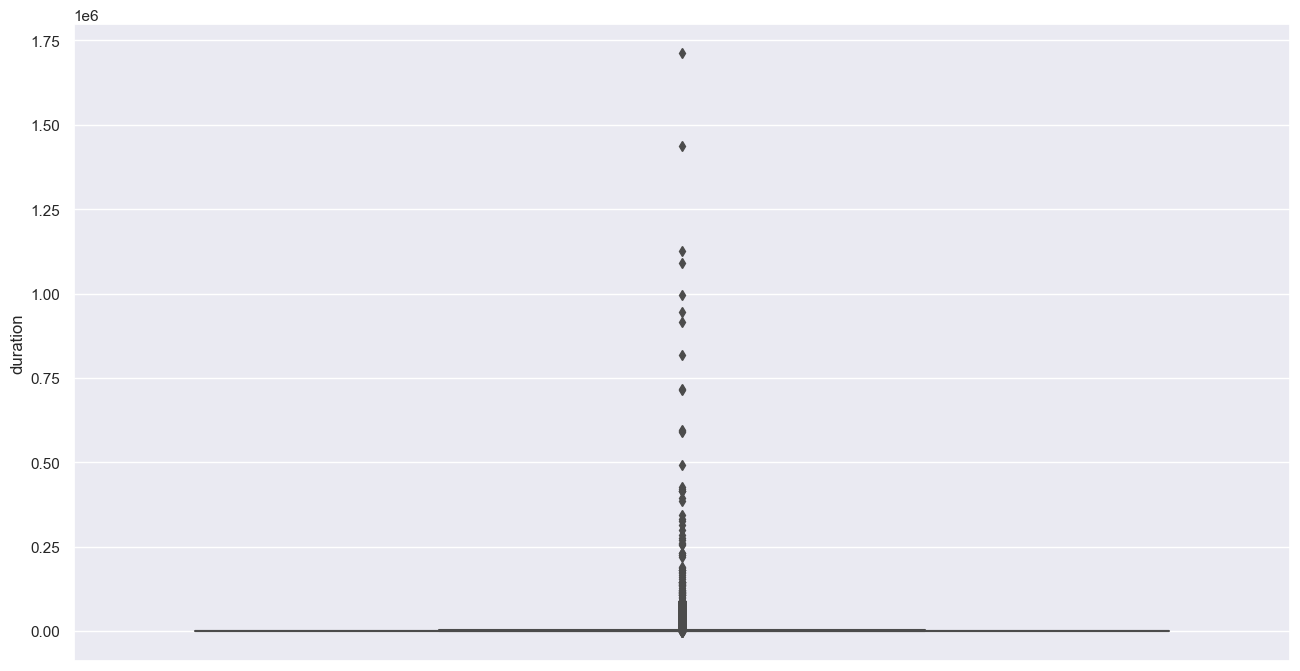

In [51]:
sns.boxplot(y=df_raw['duration'])

Removing outliers based on the above plot. We can clearly see that the we have number of fewer records that are above 5000 minutes. Filtering out those records along with additional filter to remove records over duration of 16.5 minutes.

(5201, 22)

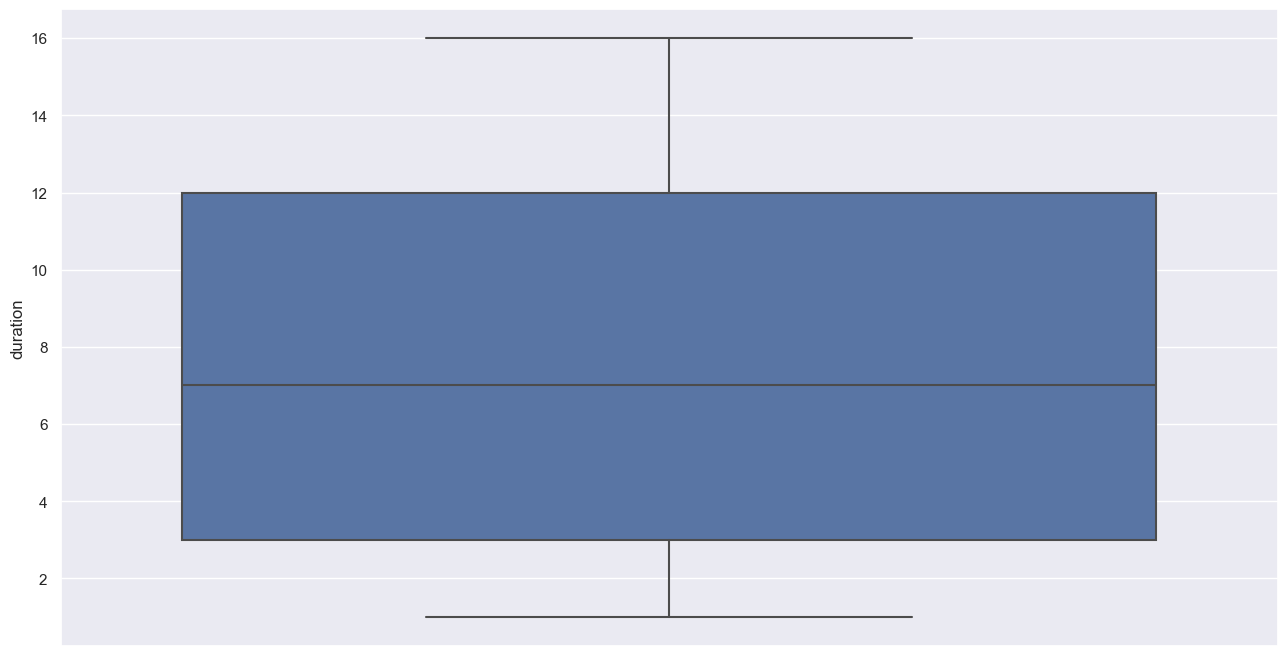

In [52]:
df_cleaned = df_raw[(df_raw['duration'] > 0) & (df_raw['duration'] < 16.5)]
sns.boxplot(y=df_cleaned['duration'])
df_cleaned.shape

In [53]:
df_casual_filter = df_cleaned[df_cleaned['member_casual'] == 'casual']
df_member_filter = df_cleaned[df_cleaned['member_casual'] == 'member']
print(df_casual_filter.shape)
print(df_member_filter.shape)

(1063, 22)
(4138, 22)


## 3.3) Check Unbalanced Data

In [54]:
df_balanced = df_cleaned[['ride_id', 'member_casual']].groupby( 'member_casual' ).count().sort_values( 'ride_id' ).reset_index()
df_balanced['perc%'] = 100*np.round( ( df_balanced['ride_id'] / np.sum( df_balanced['ride_id'] ) ), 4 )
df_balanced

,member_casual,ride_id,perc%
0,casual,1063,20.44
1,member,4138,79.56


### Here we see that the data is pretty imbalanced. Rides with members are much more compared to casual. We have 3 ways to resolve this. 
1) Resampling <br />
2) Using F1 score and assigning more weigths to the minority <br />
3) SMOTETOmek <a href='https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html'>details</a><br />
We will be looking at the third option. 

In [55]:
# Encoder
ohe = pp.OneHotEncoder()

# Columns ( Categorical + Numerical )
cols_cat = df_cleaned.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] ).drop( ['ride_id', 'member_casual'], axis=1 ).columns.tolist()
cols_num = df_cleaned.select_dtypes( include=['int64', 'float64'] ).columns.tolist()

# One Hot Encoding Categorical
df_cleaned_dummy = pd.DataFrame( ohe.fit_transform( df_cleaned[cols_cat] ).toarray(), index=df_cleaned.index )

# joining back to original dataframe
df_cleaned_encoded = pd.concat( [df_cleaned[cols_num], df_cleaned_dummy], axis=1 )

SMOTETomek is a technique for addressing class imbalance in a dataset. It is an extension of the SMOTE (Synthetic Minority Oversampling Technique) method, which is a popular technique for oversampling a minority class in a dataset.The goal of this combination is to create a balanced dataset that is more representative of the true underlying distribution of the data.

In [56]:
# Oversampling ( SMOTE ) + Undersampling ( Tomek Links )
smt = c.SMOTETomek( sampling_strategy='auto', random_state=32 )
# apply
X_smt, y_smt = smt.fit_resample( df_cleaned_encoded, df_cleaned['member_casual'] )

# numerical data
df_smote_numerical = X_smt[ cols_num ]

# categorical data
df_smote_cats = X_smt.drop( cols_num, axis=1 )
df_smote_categorical = pd.DataFrame( ohe.inverse_transform( df_smote_cats ), columns=cols_cat, index=df_smote_cats.index )

# concat Numerical and Categorical dataset
df_smote_final = pd.concat( [df_smote_numerical, df_smote_categorical], axis=1 )
df_smote_final['member_casual'] = y_smt

### Checking to see if the data is balanced after oversampling and undersampling.

In [57]:
df_smote_final['member_casual'].value_counts(normalize=True )

member    0.5
casual    0.5
Name: member_casual, dtype: float64

## 3.4) Rename Columns 

In [58]:
df_smote_final.columns

Index(['start_lat', 'start_lng', 'end_lat', 'end_lng', 'year', 'month', 'day',
       'day_of_week', 'distance', 'hour_of_day', 'duration', 'rideable_type',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'holidays', 'season', 'member_casual'],
      dtype='object')

# 4.0) - EXPLORATORY DATA ANALYSIS (EDA)

In [59]:
df_exploratory = df_smote_final.copy()

**1) Do members travel greater distances?**

In [60]:
df1 = df_exploratory[['distance', 'member_casual']].groupby( 'member_casual' ).mean().reset_index()
fig = px.bar(df1, x='member_casual', y='distance', color='member_casual', title='Casual vs Bikers member ')
fig.show()

**As you can see from the above, casual bike users travel greater distance than member bike users.**

**2) Do casual bikers ride more on holidays?**

In [61]:
#fig = px.bar(df_smote_final, x='holidays', color='member_casual')
fig = px.histogram(df_smote_final, x="holidays", color="member_casual")
fig.show()

**As we can see above, casual bikers ride more on a holiday and normal day. However, the total number of bikers are relatively smaller on a holiday.**

**3) Do member bikers ride more on weekdays?**

In [62]:
df2 =  df_smote_final.groupby(by=["day_of_week", "member_casual"]).size().reset_index(name="counts")
map_week = {0: 'Monday', 1: 'Tuesday', 2:'Wednesday', 3:'Thursday',4:'Friday',5:'Saturday', 6:'Sunday'}
df2['day_of_week'] = df2['day_of_week'].map(map_week)
fig = px.bar(df2, x="day_of_week", y="counts",color="member_casual",)
fig.show()

**Member bikers do ride more on the weekdays compared to weekends.**

**4) Do member bikers ride consistently over the months?**

In [63]:
df_1 = df_smote_final.groupby(by=["month", "member_casual"]).size().reset_index(name="counts")
map_month = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October', 
    11: 'November',
    12: 'December'
}
df_1['month'] = df_1['month'].map(map_month)
fig = px.bar(df_1, x="month", y="counts",color="member_casual",barmode="group")
fig.show()

**Member riders have been consistent over a period of time with respect to casual users. Overall usage of bike riding members have incresae in the months starting June to November.**

**5) Do casual bikers travel for long period of time?**

In [64]:
aux02 = df_smote_final[['duration', 'member_casual']].groupby( 'member_casual' ).mean().reset_index()
px.bar(aux02,x='member_casual',y='duration', color='member_casual')

**Casual bikers and member bikers ride for the same amount of time**

**6) Do member bikers ride more during daylight hours?**

In [65]:
df_3 = df_smote_final[df_smote_final['member_casual']=='member']
df_3 = df_3.groupby(by=["hour_of_day", "member_casual"]).size().reset_index(name="counts")
fig = px.bar(df_3, x="hour_of_day", y="counts" ,color='member_casual')
fig.show()

**From the above, we can see that the busy hours are between 6am and 8:30pm.**

**7) Do member bikers use more in the morning or late afternoon?**

<AxesSubplot: xlabel='hour_of_day_0', ylabel='count'>

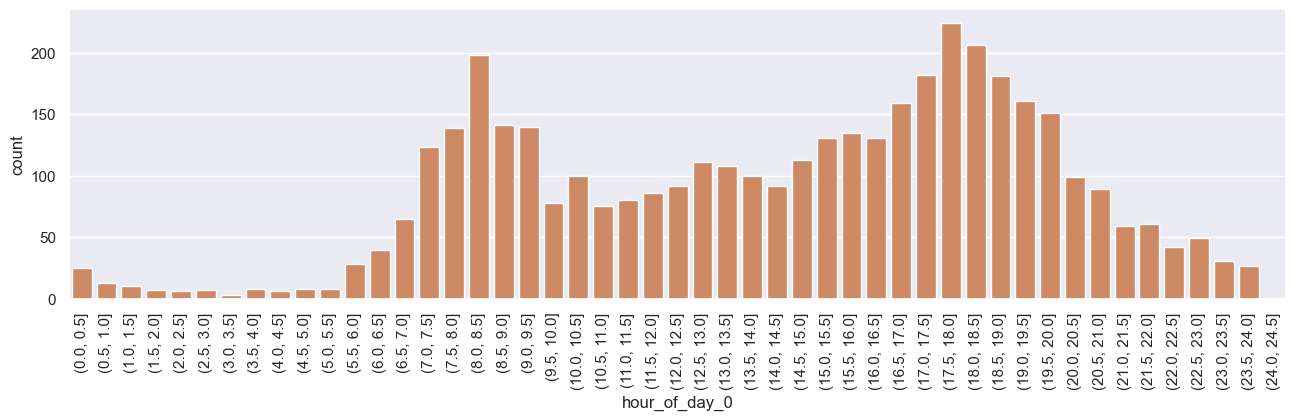

In [66]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
aux03 = df_smote_final.copy()
base_color1=sns.color_palette()[1]
base_color2=sns.color_palette()[2]


plt.subplot(2,1,1)
bins = list( np.arange(0, 25, 0.5) )
aux03['hour_of_day_0'] = pd.cut( aux03['hour_of_day'], bins=bins )
plt.xticks( rotation=90)
sns.countplot( x='hour_of_day_0', data=aux03[aux03['member_casual']=='member'],color=base_color1, 
             )



**From the above, we can clearly see that the member bikers ride more during afternoon compared to morning.**

<AxesSubplot: xlabel='hour_of_day_0', ylabel='count'>

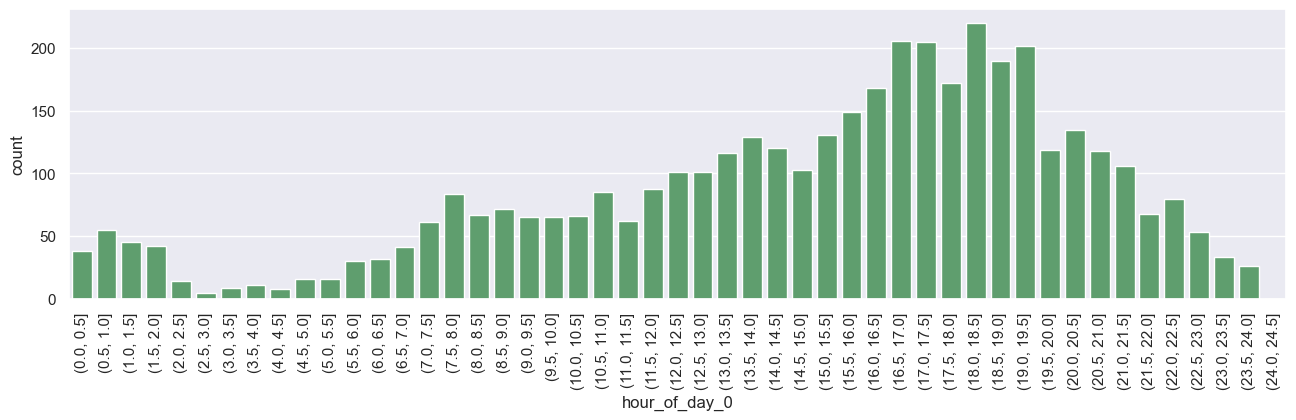

In [67]:
plt.subplot(2,1,2)
bins = list( np.arange(0, 25, 0.5) )
aux03['hour_of_day_0'] = pd.cut( aux03['hour_of_day'], bins=bins )
plt.xticks( rotation=90)
sns.countplot( x='hour_of_day_0', data=aux03[aux03['member_casual']=='casual'], color=base_color2)

**Similar to member bikers, casual bikers ride more during afternoon compared to early morning.**

**8) Do casual bikers ride more in the summer compared to other seasons?**

In [68]:
df12 =  df_smote_final.groupby(by=["season", "member_casual"]).size().reset_index(name="counts")
fig = px.bar(df12, x="season", y="counts",color="member_casual",)
fig.show()

**From the above, it is pretty clear that casual bike riders ride more during the summer season compared to other seasons.**

**9) How do the rideable types vary in weekdays?**

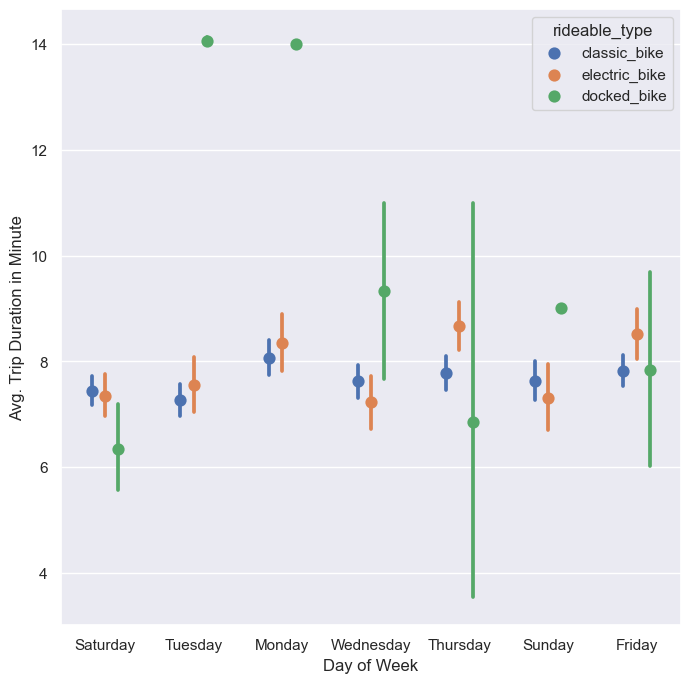

In [69]:
plt.figure(figsize = [8, 8])
df_4 = df_smote_final[['day_of_week','duration','rideable_type']]
df_4['day_of_week'] = df_4['day_of_week'].map(map_week)
sns.pointplot(data=df_4, x='day_of_week', y='duration', hue='rideable_type', dodge=0.3, linestyles="");
plt.xlabel('Day of Week');
plt.ylabel('Avg. Trip Duration in Minute');

**From the above, we can see that the docked bike is used more during wednesday, thursday and friday.**

**9)Compare the bike type usage on normal day with a holiday.**

<AxesSubplot: xlabel='holidays'>

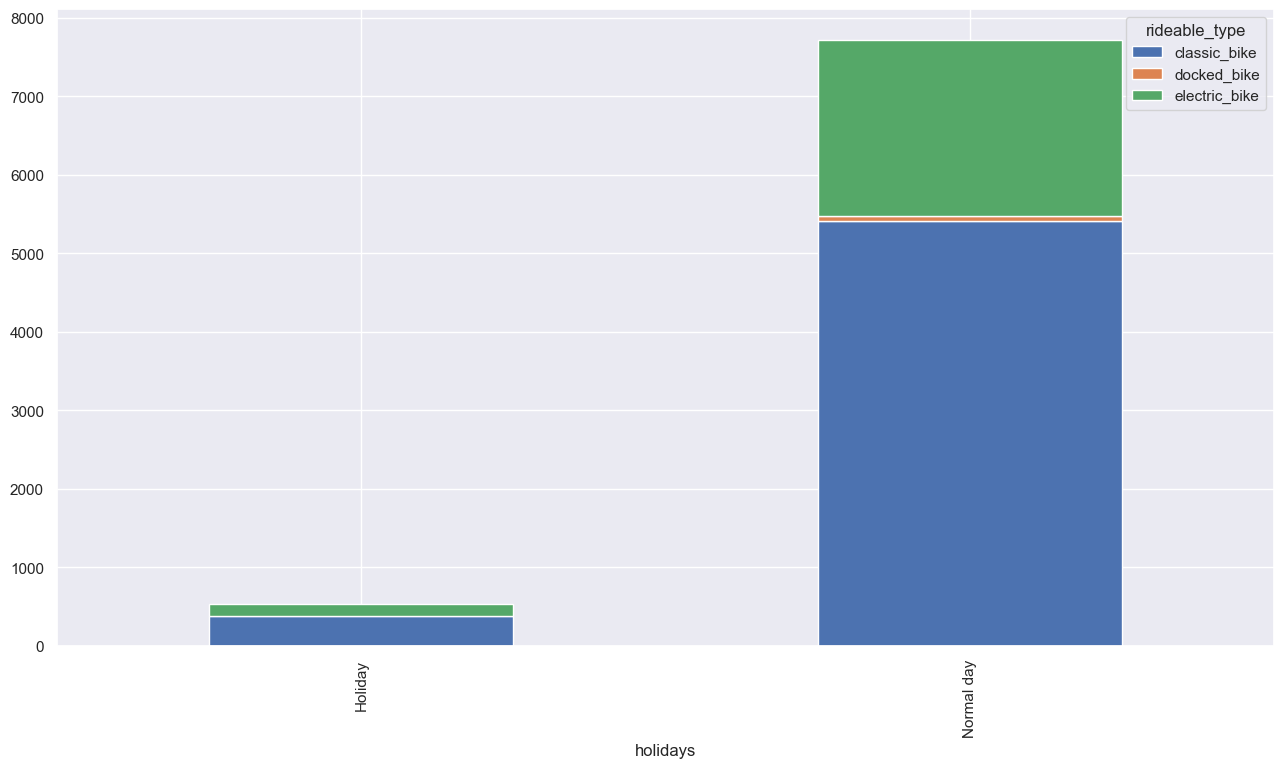

In [70]:
 df_smote_final.groupby(['holidays', 'rideable_type'])['holidays'].count().unstack('rideable_type').plot(kind='bar', stacked=True)

**From the above, we can see that the classic bike and electric bikes are driven more compared to docked bike.** 

**10) Which start station was the most popular?**

In [75]:
df2 =  df_smote_final.groupby(by=["start_station_name", "member_casual"]).size().reset_index(name="counts")
fig = px.bar(df2, x='start_station_name', y='counts', color='member_casual', title='Starting Station by Member type')
fig.show()

**From the above, we can see that the two stations that are most popular are Grove St Path and South Waterfron Walkway - Sintara Dr & 1st.**

**11) Which end stations are most popular?**

In [76]:
df2 =  df_smote_final.groupby(by=["end_station_name", "member_casual"]).size().reset_index(name="counts")
fig = px.bar(df2, x='end_station_name', y='counts', color='member_casual', title='Ending Station by Member type')
fig.show()

**From the above, we can see that the two stations that are most popular are Grove St Path and South Waterfron Walkway - Sintara Dr & 1st.**

**The relationship between the multiple variables plotted are visualized altogether and information are presented combined.The efficient/short period of usage for royal customers corresponds to their high concentration on Monday through Friday, indicating the use is primarily for the work commute. The more relaxing and flexible pattern of customer use shows that they're taking advantage of the bike-sharing system quite different from the royal customers, heavily over weekends and in the afternoon, for city tour or leisure purpose probably.**